# Modelling Design Report Performance based on Nephrotex Virtual Internship Chat Data 

## Background 

The goal of this project is to model students final design report performance (a final score) based on chat data from their virtual internship at Nephrotex. 

**[Nephrotex](https://www.virtualinterns.org/nephrotex/)** is a virtual internship in which students play the role of interns in a fictitious biomedical engineering design firm. They are required to design a novel nanotechnology-based membrane that can be used for kidney dialysis. To do this they use internal technical documents, background research, and research reports based on experimental data. The students have to develop and test hypotheses, as well as appeal to company stakeholders who have a stake in the outcome of the devices that they develop. 

This chat data is collected from the chat features of an online platform that the students have used to complete the virtual internship. This platform is called WorkPro. This allows virtual communication between teammates and the design advisor (mentor). 


We will be looking to achieve our goal by looking at different variables related to design moves and design justifications, along with how language used in the chat can effect a students final score. We aim to find correlations to determine which 3 factor's can best predict a student's final score (A mark between 0 and 8, where 0 is low quality and 8 is high quality.)

### Description of room names
Each room name represents the phases of a team's project. A brief description of each of them is given below in the chronological order of the project's workflow.

`Introduction and Workflow Tutorial with Entrance Interview`: This room serves as an induction for interns and allows both mentors and interns get to know each other

`Background research on dialysis`: This room's purpose is for interns to discuss the optimal existing treatments for patients' kidneys so that the team's product can be inspired by these ideas for treating kidney failure. Dialysis describes the treatment used to act as a replacement for a patient's kidneys with regards to functioning, in the event of kidney failure. 

`Choose consultants to analyze`: This room enables interns to discuss which external advisors are the most effective at conveying information about patients' condition with regards to their physiological state, so that their products can best meet patients' needs.

`Summarize internal consultant requirements`: This room enables interns to discuss how they can satisfy patients' needs based on the advice they have been given by the consultants they had previously chosen

`Graphing Surfactant Data`: This room's purpose is to visualise the effects of different types of surfactants on patients' kidneys. The general role of a surfactant is to reduce the surface tension of blood vessels in the lungs and kidneys so that pathogenic fluids and waste can be removed from the body. 

`Reflection team discussion of surfactants`: This room allows the team to discuss the results of the surfactants' effecitveness in improving kidney function. 

`Individuals design 5 prototypes`: This room serves as an ideation space for individuals to brainstorm potential ideas. By the end of this phase, individuals are required to realise at least 5 ideas in the form of prototype designation.

`Individual analysis of first batch`: Individuals analyse and reflect upon the advantages and disadvantages of the their prototypes.

`Team designs batch using 1 material`: This room contains the team's final design to be submitted as part of the first round of designs for Nephrotex. 

`Reflection team discussion of first batch results`: This room allows the team to discuss the effectiveness of their prototype submission and how to improve in later attempts. 

In [2]:
 # Import all required libraries 

import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np 
from sklearn.metrics import accuracy_score,recall_score,precision_score
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,accuracy_score,recall_score,precision_score,confusion_matrix
from sklearn.model_selection import cross_validate, RepeatedKFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso # models we are going to use
from sklearn.metrics import r2_score # for comparing the predicted and test values
from sklearn.tree import DecisionTreeClassifier, plot_tree
from logitplots import plt_confusion_matrix, plt_decision_boundaries, plt_correlation_matrix
import warnings
from sklearn.svm import SVC
warnings.filterwarnings("ignore")#ignore warnings
RS=42#set consistent random state for all model testing

### Variables in the Nephrotex Dataset:

The dataset contains the chat records from 15 implementations of Nephrotex. They are labelled with the presence and absence of various concepts in engineering discourse relating to design moves and design justifications. We want to model a students perfomance on the report based on what they have discussed within the chat throughout the internship. 

- `UserIDs` = a unique id for each student
- `implementation` = id for each implementation of nephrotex (there were 15 implementations)
- `Line_ID` = unique Id for the chat utterance
- `ChatGroup` = id for the team the chatter was in. (String values are the teams from the first half of the internship, numeric are the teams from the second part of the intership - interns swapped teams halfway through) 
- `content` = content of the chat utterance
- `group_id` = numerical id for the team the chatter was in
- `RoleName` = Chatter was a **Mentor** or **Player** 
- `roomName` = the internship activity that the chatter was participating in
- `OutcomeScore`  = A mark from 0 -> 8 indicating quality of the chatter's final design report. (Not everyone in the same group got the same score)
-  `wordCount`  = no. of words in chat content

Design <u>Moves</u> (Dummy Variables)
- `m_experimental_testing` = talks about using experimental techniques to understand the technical features of the design 
- `m_making_design_choices` = talks about choosing a specification or characteristic for a design. 
- `m_asking_questions` = asks a question

Design <u>justifications</u> (Dummy Variables)
- `j_customer_consultants_requests` = states whether they should meet or exceed stakeholder requests
- `j_performance_parameters_requirements`  = refers to performance parameters or experimental results
- `j_communication`  = refers to how it can facilitate communication among the engineers

In [3]:
def swap_columns(df, col1, col2):#define misc. function to swap columns in dataframe
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

The first step in this project is to process the data so it can be visualised and properly manipulated for modelling. In this first instance, the data is processed in such a way that only quantitative features with relevant roles in predicting outcome score are used.

In [4]:
chatData=pd.read_csv('VI_data.csv',encoding='latin1')
# Examine dimensionality of the raw data

print(chatData.shape)

(19180, 17)


In [5]:
chatData

,Unnamed: 0,userIDs,implementation,Line_ID,ChatGroup,content,group_id,RoleName,roomName,m_experimental_testing,m_making_design_choices,m_asking_questions,j_customer_consultants_requests,j_performance_parameters_requirements,j_communication,OutcomeScore,wordCount
0,1,1,a,1,PRNLT,Hello team. Welcome to Nephrotex!,2,Mentor,Introduction and Workflow Tutorial with Entran...,0,0,0,0,0,0,4,5
1,2,1,a,2,PRNLT,I'm Maria Williams. I'll be your design adviso...,2,Mentor,Introduction and Workflow Tutorial with Entran...,0,0,0,0,0,0,4,11
2,3,1,a,3,PRNLT,I'm here to help if you have any questions.,2,Mentor,Introduction and Workflow Tutorial with Entran...,0,0,0,0,0,0,4,9
3,4,1,a,4,PRNLT,Please introduce yourselves with the name you ...,2,Mentor,Introduction and Workflow Tutorial with Entran...,0,0,0,1,0,0,4,51
4,5,1,a,5,PRNLT,I just want to make sure everyone has found th...,2,Mentor,Introduction and Workflow Tutorial with Entran...,0,0,0,0,0,0,4,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19175,19176,392,o,19179,PESPVP,yes,6,Player,Reflection team discussion of first batch results,0,0,0,0,0,0,5,1
19176,19177,388,o,19180,PESPVP,sounds good,6,Player,Reflection team discussion of first batch results,0,0,0,0,0,0,8,2
19177,19178,367,o,19181,PESPVP,"Well, we are out of time for our meeting.",6,Mentor,Reflection team discussion of first batch results,0,0,0,0,0,0,4,9
19178,19179,393,o,19182,PESPVP,Precisely,6,Player,Reflection team discussion of first batch results,0,0,0,0,0,0,4,1


In [6]:
# Any missing values? If yes -> must delete or impute

chatData.isnull().sum()

Unnamed: 0                               0
userIDs                                  0
implementation                           0
Line_ID                                  0
ChatGroup                                0
content                                  0
group_id                                 0
RoleName                                 3
roomName                                 0
m_experimental_testing                   0
m_making_design_choices                  0
m_asking_questions                       0
j_customer_consultants_requests          0
j_performance_parameters_requirements    0
j_communication                          0
OutcomeScore                             0
wordCount                                0
dtype: int64

Since the proportion of empty values is insignificant, dropping these values seems appropriate.

In [7]:
chatData.info()#do secondary check of empty values in all quantitative columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19180 entries, 0 to 19179
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   Unnamed: 0                             19180 non-null  int64 
 1   userIDs                                19180 non-null  int64 
 2   implementation                         19180 non-null  object
 3   Line_ID                                19180 non-null  int64 
 4   ChatGroup                              19180 non-null  object
 5   content                                19180 non-null  object
 6   group_id                               19180 non-null  int64 
 7   RoleName                               19177 non-null  object
 8   roomName                               19180 non-null  object
 9   m_experimental_testing                 19180 non-null  int64 
 10  m_making_design_choices                19180 non-null  int64 
 11  m_asking_questi

In [8]:
#creating a player only data frame
chatData=swap_columns(chatData,'OutcomeScore','wordCount')
chatData1=chatData.drop(chatData.columns[0],axis=1)#drop unamed column
chatData1=chatData1.drop(['ChatGroup','content','roomName','Line_ID'],axis=1)#remove text data
mask=chatData['RoleName']=='Mentor'#set condition to mentor data only
chatData1=chatData1.drop(chatData[mask].index)#drop all mentor data only
chatData1=chatData1.dropna()#drop the Nan value
teams=chatData1.groupby(['userIDs','implementation','group_id']).sum()#group players by id and get sum of each quantitative stat
scores=chatData1.drop_duplicates(subset=['userIDs','implementation','group_id'])#get score of each player
teams['Outcome_Score']=scores['OutcomeScore'].values#add outcome score column in data set so each player has a score from 0-7 instead of cumulative
teams=teams.drop(teams.columns[7],axis=1)#drop original cumulative outcome score column
teams=teams.rename(columns={'Outcome_Score':'OutcomeScore'})
#creating mentor only data frame repeating same steps
chatData2=chatData.drop(chatData.columns[0],axis=1)
chatData2=chatData2.drop(['ChatGroup','content','roomName','Line_ID'],axis=1)
mask=chatData2['RoleName']=='Player'
chatData2=chatData2.drop(chatData2[mask].index)
chatData2=chatData2.dropna()
men_teams=chatData2.groupby(['userIDs','implementation','group_id']).sum()
men_teams=men_teams.drop(["OutcomeScore"],axis=1)

The data was wrangled by using the identifier columns, such as `userID`, `implementation` and `group_id` to separate interns into different instance objects with a unique set of quantitative attributes. For example, after the wrangling process, an intern would be identifed by the aforementioned keys and contained the frequency distribution of the types of messages they sent, the total number of words they typed and most importantly, their outcome score. To get a more complete and general picture of the most common and least common types of messages sent by interns over the whole program's period of operation, a bar plot has been generated. 

,userIDs,implementation,group_id,RoleName,m_experimental_testing,m_making_design_choices,m_asking_questions,j_customer_consultants_requests,j_performance_parameters_requirements,j_communication,wordCount,OutcomeScore
5,2,a,2,Player,0,0,0,0,0,0,4,4
6,3,a,2,Player,0,0,0,0,0,0,3,4
7,3,a,2,Player,0,0,0,0,0,0,1,4
8,4,a,2,Player,0,0,0,0,0,0,3,4
9,5,a,2,Player,0,0,0,0,0,0,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...
19173,391,o,6,Player,0,0,0,0,0,0,1,5
19174,389,o,6,Player,0,0,0,0,0,0,2,7
19175,392,o,6,Player,0,0,0,0,0,0,1,5
19176,388,o,6,Player,0,0,0,0,0,0,2,8


,userIDs,implementation,group_id,RoleName,m_experimental_testing,m_making_design_choices,m_asking_questions,j_customer_consultants_requests,j_performance_parameters_requirements,j_communication,wordCount,OutcomeScore
5,2,a,2,Player,0,0,0,0,0,0,4,4
6,3,a,2,Player,0,0,0,0,0,0,3,4
8,4,a,2,Player,0,0,0,0,0,0,3,4
9,5,a,2,Player,0,0,0,0,0,0,3,2
10,6,a,2,Player,0,0,0,0,0,0,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...
18866,389,o,6,Player,0,0,0,0,0,0,3,7
18867,390,o,6,Player,0,0,0,0,0,0,1,4
18868,391,o,6,Player,0,0,0,0,0,0,1,5
18869,392,o,6,Player,0,0,0,0,0,0,3,5


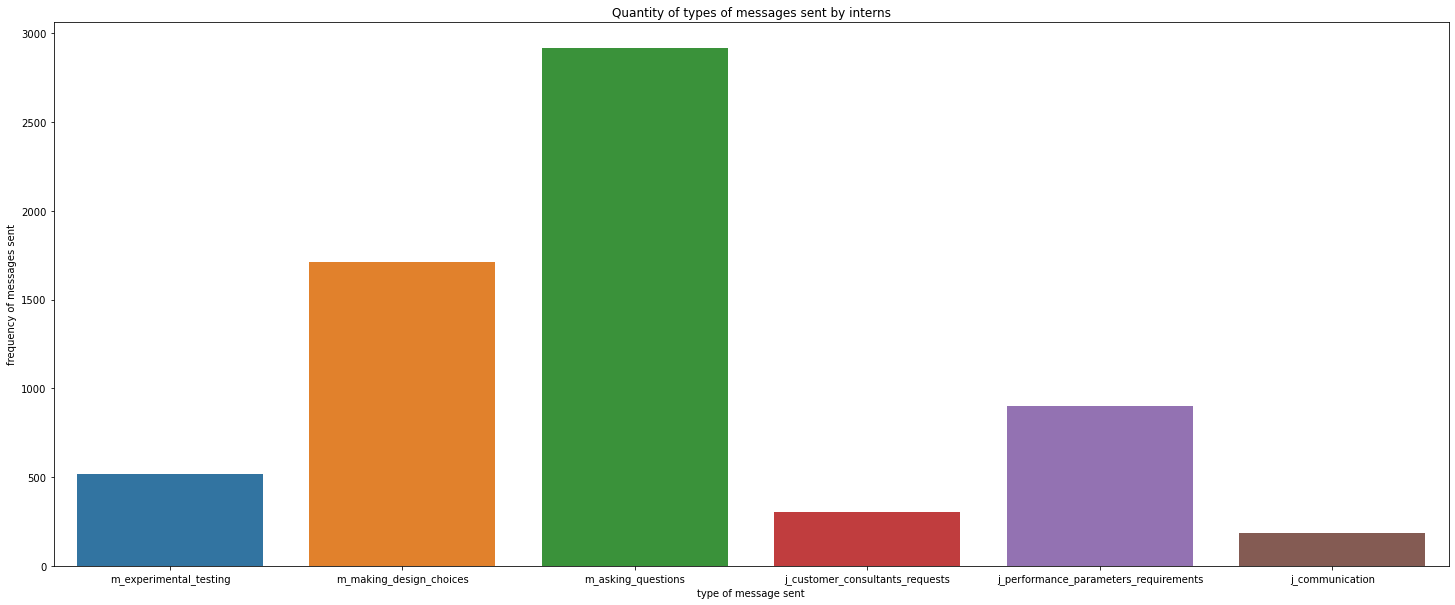

In [10]:
message_sum_graph=pd.DataFrame(teams.sum()).drop(['OutcomeScore','wordCount'],axis=0).transpose()
f, ax = plt.subplots(figsize=(25, 10))
sns.barplot(data=message_sum_graph)
plt.title('Quantity of types of messages sent by interns')
plt.ylabel('frequency of messages sent')
plt.xlabel('type of message sent')
plt.show()

According to the graph above, the most common type of message sent by interns was the `m_asking_questions` type of message, which may imply that interns mainly used the chatting app to communicate with mentors about the aspects of the project that they were uncertain of. Interestingly, the rarest types of messages sent were `j_communication` and `j_customer_consultant_requests`, which could indicate that interns either were not very coordinated when it came to expressing ideas in a team, or used other means of communication, and did not consider clients' needs when given the opportunity to receive advice from consultants or had limited contact hours with consultants. Both events could explain the presence of a significant volume of interns who performed below average, as shown in the next figure. 

The process is repeated for the mentors to see if there is an insightful relationship between the distributions of messages. As observed, these proportional distributions are very similar, perhaps except for the frequency of communicative messages, which appears to be moderately higher because mentors tend to convey a higher volume of miscellaneous messages to interns to ensure the program runs smoothly. An example would be introducing themselves to interns.

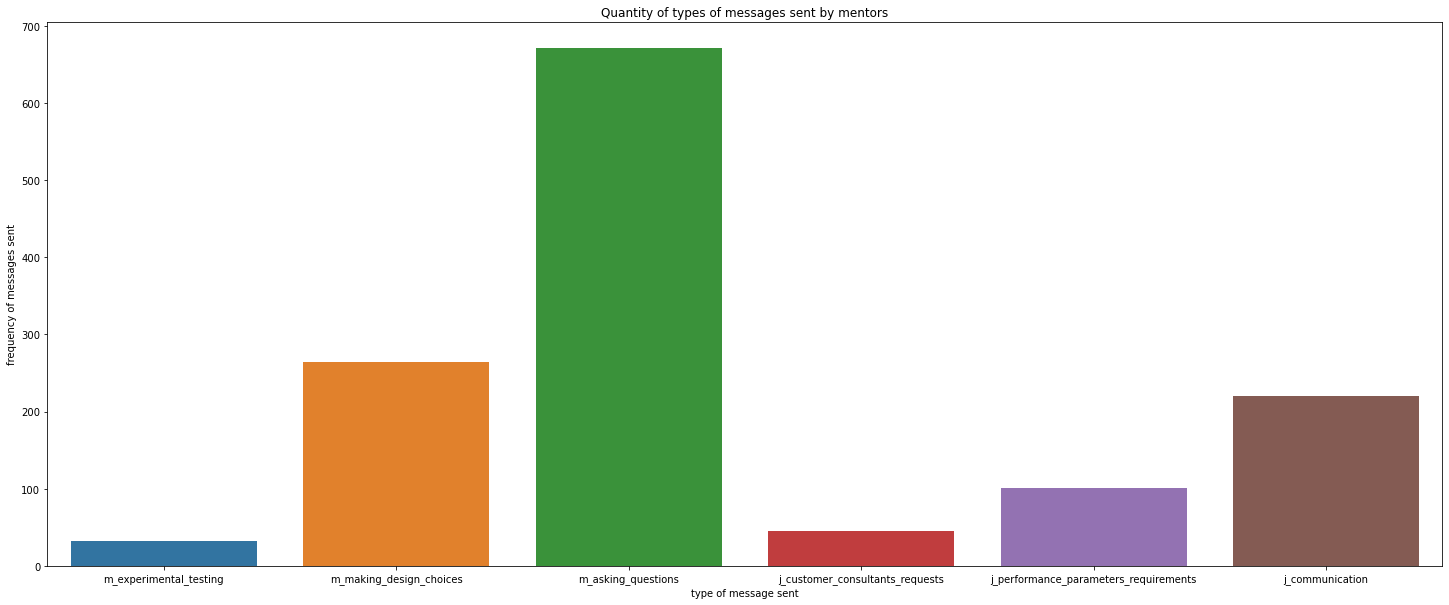

In [11]:
message_sum_graph=pd.DataFrame(men_teams.drop('wordCount',axis=1).sum()).transpose()
f, ax = plt.subplots(figsize=(25, 10))
sns.barplot(data=message_sum_graph)
plt.title('Quantity of types of messages sent by mentors')
plt.ylabel('frequency of messages sent')
plt.xlabel('type of message sent')
plt.show()

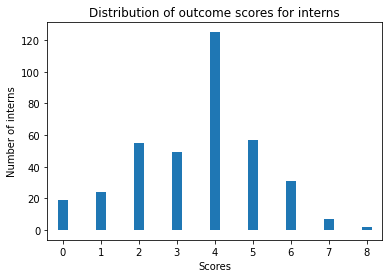

In [12]:
dist_scores=teams['OutcomeScore']
data=np.array(dist_scores)
values, counts = np.unique(data, return_counts=True)
plt.vlines(values, 0, counts, color='C0', lw=10)
plt.title('Distribution of outcome scores for interns')
plt.xlabel('Scores')
plt.ylabel('Number of interns')
plt.show()

According to the distribution of scores, it can be safely assumed that the typical score achieved by interns is 4 and the majority of students fall in the range below this score. Very few students achieved the top score. As majority of interns achieved lower scores, the data is slightly skewed to the left, albeit not too greatly because a significant proportion of interns still achieved a score above the typical score.

The performance of interns can be examined more closely by separating interns by `implementation` to observe how outcome scores have varied over different internships. The visual relationship between the quantity of types of messages sent by interns can also be examined more closely.

In [13]:
sort_teams=chatData1.groupby(['userIDs','implementation',]).sum()
scores=chatData1.drop_duplicates(subset=['userIDs'])
sort_teams['Outcome_Score']=scores['OutcomeScore'].values
sort_teams=sort_teams.drop(teams.columns[7],axis=1)
sort_teams=sort_teams.reset_index()

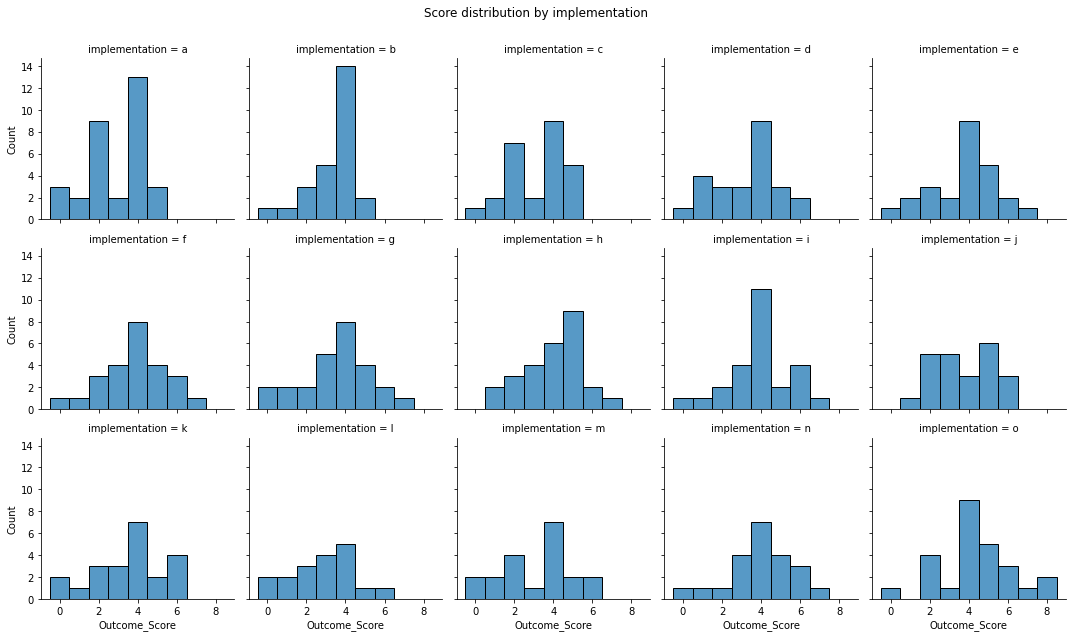

In [14]:
g = sns.FacetGrid(sort_teams, col="implementation",col_wrap=5)
g.map(sns.histplot,'Outcome_Score',discrete=True)
g.fig.suptitle('Score distribution by implementation')
g.fig.subplots_adjust(top=0.9)
plt.show()

In [15]:
implementation_variables = teams.reset_index()
implementation_variables = implementation_variables.drop(['userIDs', 'group_id'], axis=1)

implementation_variables = implementation_variables.groupby(['implementation']).sum()

implementation_variables = implementation_variables.reset_index()

# implementation_variables = implementation_variables.drop(['OutcomeScore', 'wordCount'], axis=1)

implementation_variables = implementation_variables.drop(['wordCount','OutcomeScore'], axis=1)

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'d'}>,
        <AxesSubplot:title={'center':'e'}>],
       [<AxesSubplot:title={'center':'f'}>,
        <AxesSubplot:title={'center':'g'}>,
        <AxesSubplot:title={'center':'h'}>,
        <AxesSubplot:title={'center':'i'}>,
        <AxesSubplot:title={'center':'j'}>],
       [<AxesSubplot:title={'center':'k'}>,
        <AxesSubplot:title={'center':'l'}>,
        <AxesSubplot:title={'center':'m'}>,
        <AxesSubplot:title={'center':'n'}>,
        <AxesSubplot:title={'center':'o'}>]], dtype=object)

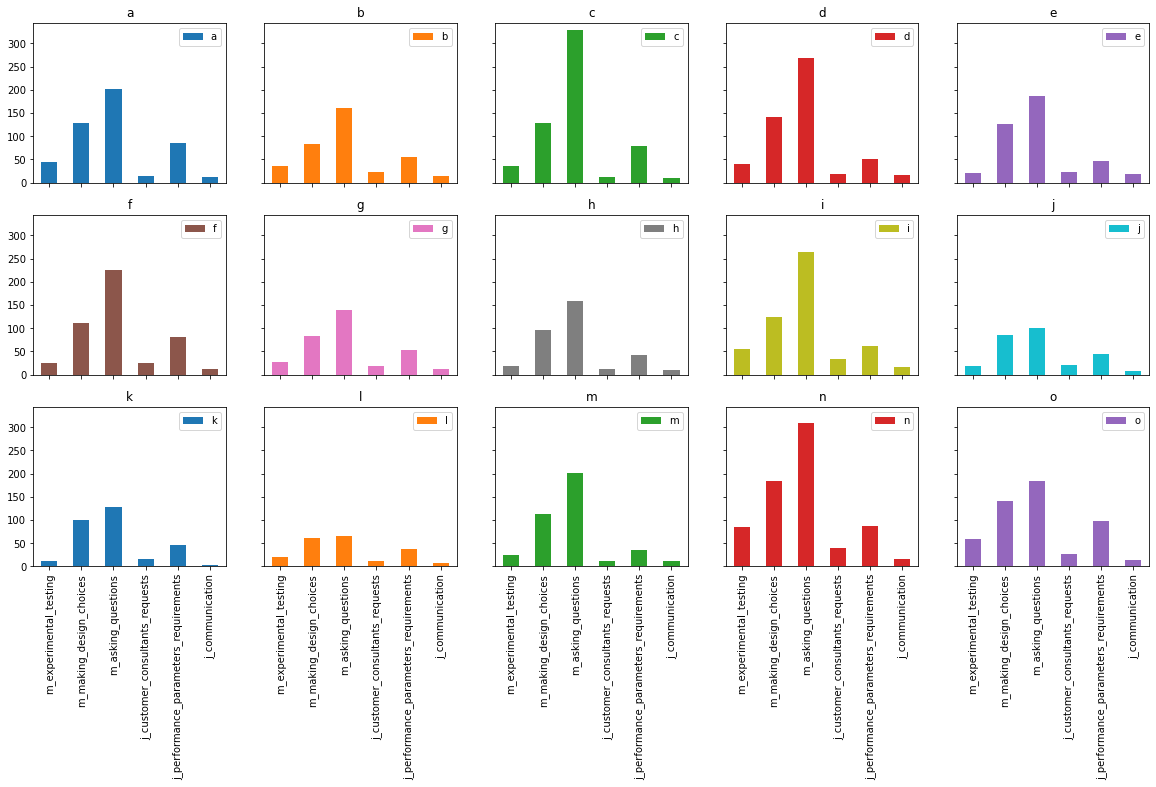

In [16]:
implementation_graph=implementation_variables.set_index('implementation').T
implementation_graph.plot(kind='bar', subplots=True, layout=(3, 5), figsize=(20, 10), sharey=True, title=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n',
       'o'])

Upon comparing the details of each implementation, the proportional distribution of types of messages sent remains relatively consistent whilst the distribution of scores varies. This may imply a poor connection between the frequency of types of messages sent and the outcome score. However, further investigation is required to affirm this.

In [17]:
def plt_correlation_matrix(corrs):
    '''Uses the seaborn heatmap to plot the correlation matrix of a pandas dataframe''' 
    # as this is a symmetric table, set up a mask so that we only plot values 
    # below the main diagonal
    mask = np.triu(np.ones_like(corrs, dtype=np.bool))
    f, ax = plt.subplots(figsize=(10, 8)) # initialise the plots and axes
    # plot the correlations as a seaborn heatmap, with a colourbar
    sns.heatmap(corrs, mask=mask, center=0, annot=True, square=True, linewidths=.5) 
    # do some fiddling so that the top and bottom are not obscured
    bottom, top = ax.get_ylim() 
    ax.set_ylim(bottom + 0.5, top - 0.5)

To quantify the effects of different features on outcome score, a heatmap has been generated to indicate potential attributes that may become key factors that affect interns' future performance. The correlations are calculated using a linear regression model fitted to the data.

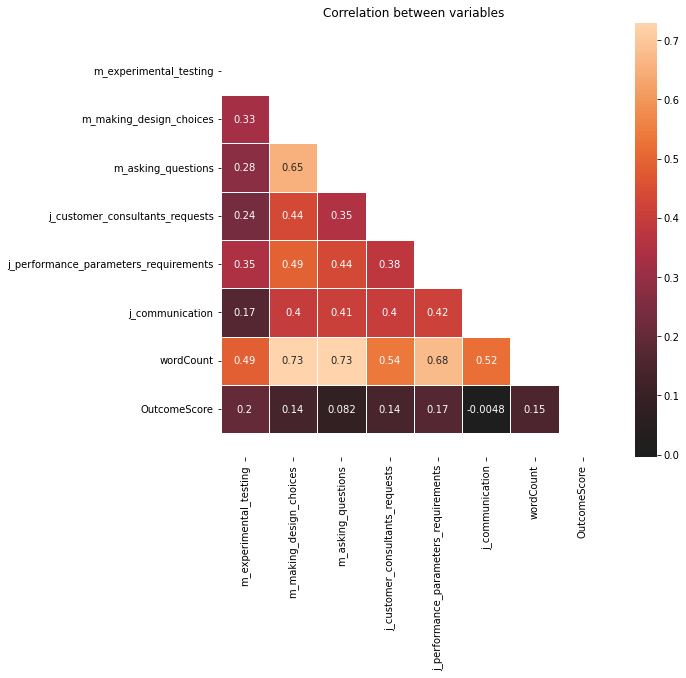

In [18]:
plt_correlation_matrix(teams.corr())
plt.title('Correlation between variables')
plt.show()

The most significant factors influencing `OutcomeScore` appear to be `m_experimental_testing` and `j_performance_parameters_requirements` whilst `j_communication` and `m_asking_questions` appear to have the least effect on score, relatively speaking, albeit the correlation for all factors is low. Therefore, more concrete evidence is required and can be found using feature importance functions of different types of models. A concerning result in this correlation matrix pertains to the fact that there may be some colinearity issues particularly because the correlation between the other variables is high in some cases, making it difficult to distinguish the individual effects of each variable on outcome score.

In [19]:
teams=teams.drop(['wordCount'],axis=1)
X=teams.drop(['OutcomeScore'],axis=1)
y=teams['OutcomeScore']
nX=(X-X.mean())/X.std()

### Linear Regression

The first approach was to normalise all features and map all potential relationships between each feature and outcome score to compare significance of features in affecting scores. The main issues with this approach will be outlined below.

In [20]:
X_train, X_test, y_train, y_test =train_test_split(nX,y,test_size=0.2, random_state=RS)
linear = LinearRegression()
linear.fit(X_train,y_train)
y_pred = linear.predict(X_test) 

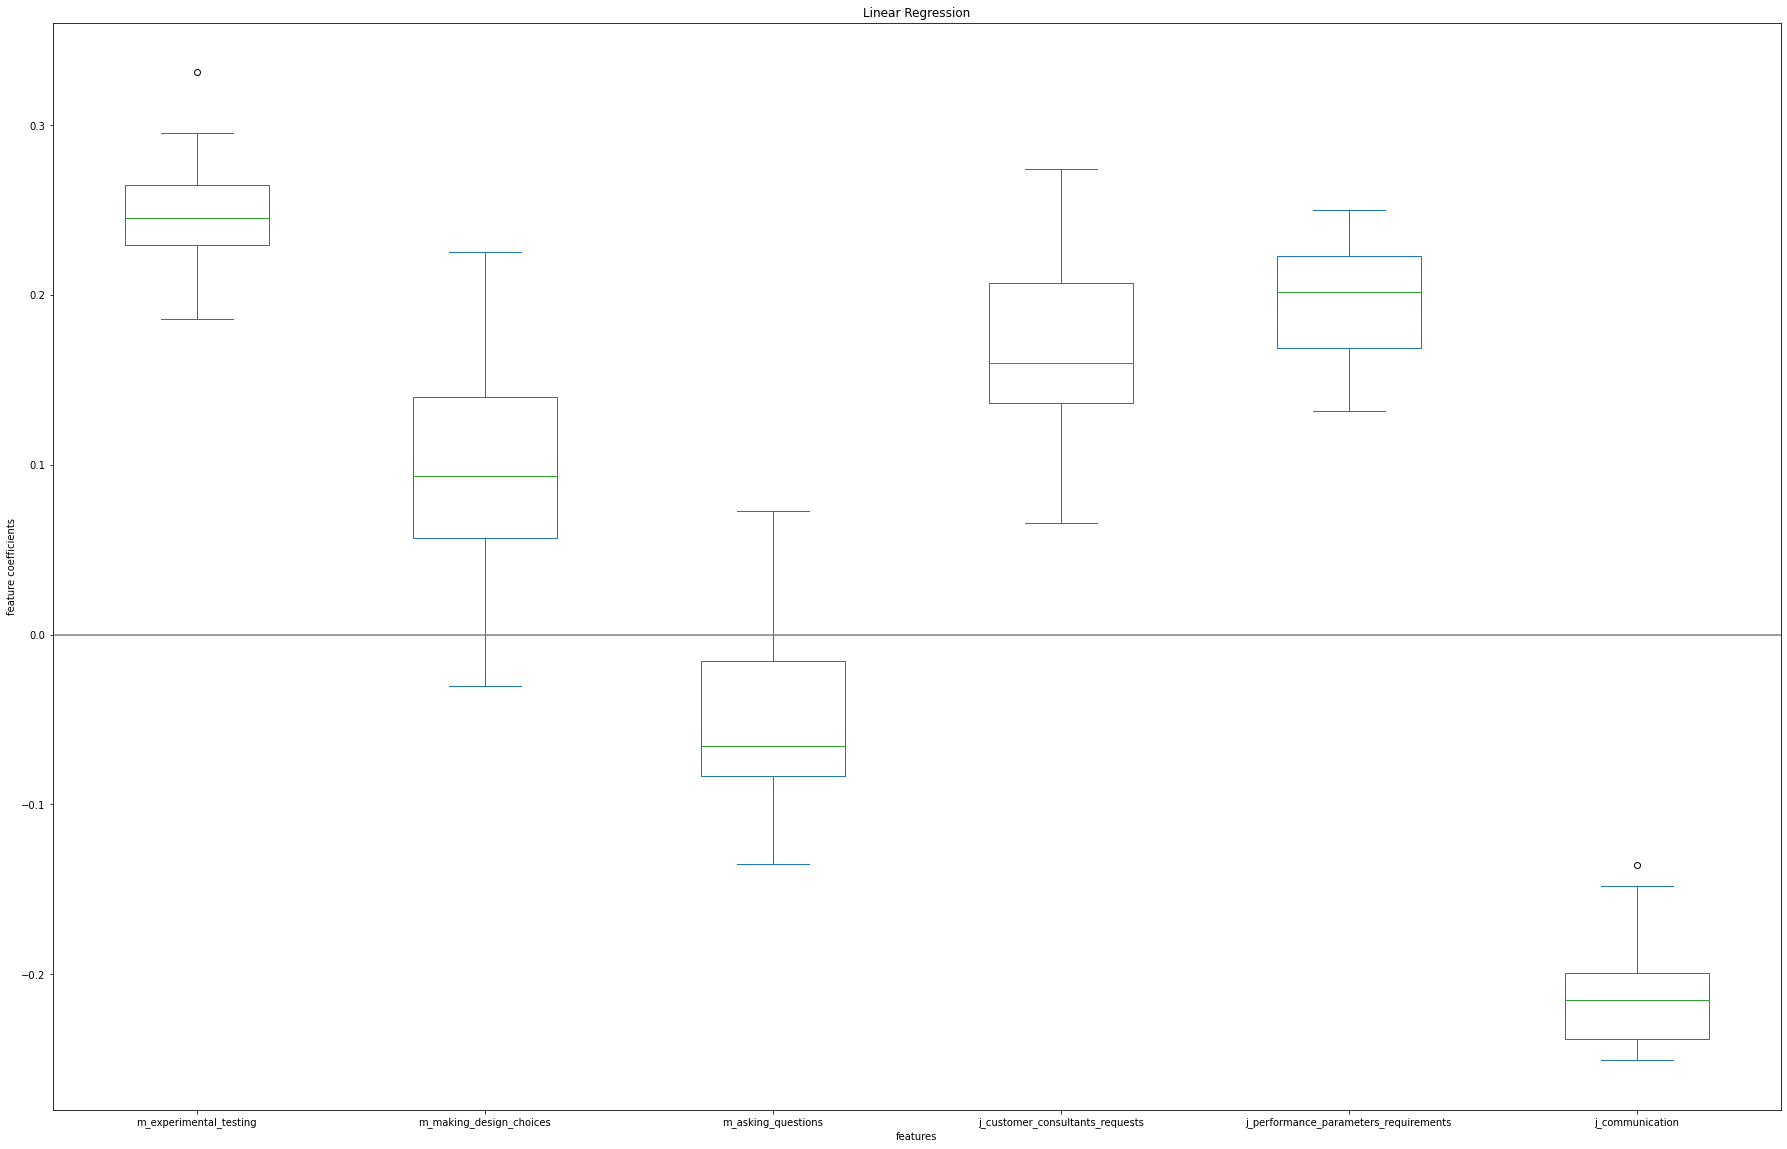

In [21]:
feature_names = X.columns.tolist()
feature_scores = cross_validate(
    linear, nX, y,
    cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=np.random.RandomState(RS)),
    return_estimator=True,
)
coefs = pd.DataFrame([est.coef_ for est in feature_scores['estimator']], columns=feature_names)
ax = coefs.plot(kind='box',figsize=(30,20))
plt.title('Linear Regression')
plt.xlabel('features')
plt.ylabel('feature coefficients')
plt.axhline(y=0, color='.5')
plt.subplots_adjust(left=.1)
plt.show()

The graph above demonstrates that the coefficients have moderate variability for the all variables. The variable, `j_communication` appears to have the worst effect on `OutcomeScore` but this finding may not be as statistically significant as the other variables' effects on `OutcomeScore` because the correlation between `j_communication` and `OutcomeScore` is relatively low compared to other variables, as seen in the correlation matrix. `m_experimental_testing`, the variable with the highest correlation to `OutcomeScore` and seems to have positive effect on outcome score.

In [22]:
pd.DataFrame({
    "R^2": {
        "Results": r2_score(y_test,y_pred)
    },
    "RMSE": {
        "Results": mean_squared_error(y_test,y_pred, squared=False),
    },
    "MAE": {
        "Results": mean_absolute_error(y_test,y_pred),
    }
})

,R^2,RMSE,MAE
Results,-0.112264,1.623714,1.371916


According to the accuracy metrics, the R^2 in particular, linear regression is an inappropriate choice to model feature importance because R^2 scores close to 0 indicate extremely poor fitting results to the data. The reasons for this may be that predicting scores may not be a regression problem or the data is unlikely to be linear. Therefore, classification algorithms may need to be used instead or another type of regression model may need to be explored.

### Decision Trees (Classifier)

Decision trees was the next simple approach to be taken. It involves splitting data at nodes to classify them at different levels of 'purity'. The gini score or index is used to quantify the randomness present in the data after each split.Therefore, a higher gini index indicates less purity. Since decision trees operate on a relative scale, no normalisation of features needs to occur. This model was chosen because of the need to choose a classifier that could express feature importance. The model was also ideal because it operated in a relative scope meaning no normalisation was required. 

In [23]:
classes=sorted(set(y))
for i in range(len(classes)):
    classes[i]=str(classes[i])
X=teams.drop(['OutcomeScore'],axis=1)
y=teams['OutcomeScore']
X_train, X_test, y_train, y_test =train_test_split(X,y,test_size=0.2, random_state=RS)

parameters={'min_samples_leaf':range(1,10)
           }
dtc=DecisionTreeClassifier(random_state=RS)
clf = GridSearchCV(estimator=dtc, param_grid=parameters,cv=3,scoring='accuracy')
clf.fit(X_train,y_train)
print(f"GridSearchCV parameters: {clf.best_estimator_}")


GridSearchCV parameters: DecisionTreeClassifier(min_samples_leaf=6, random_state=42)


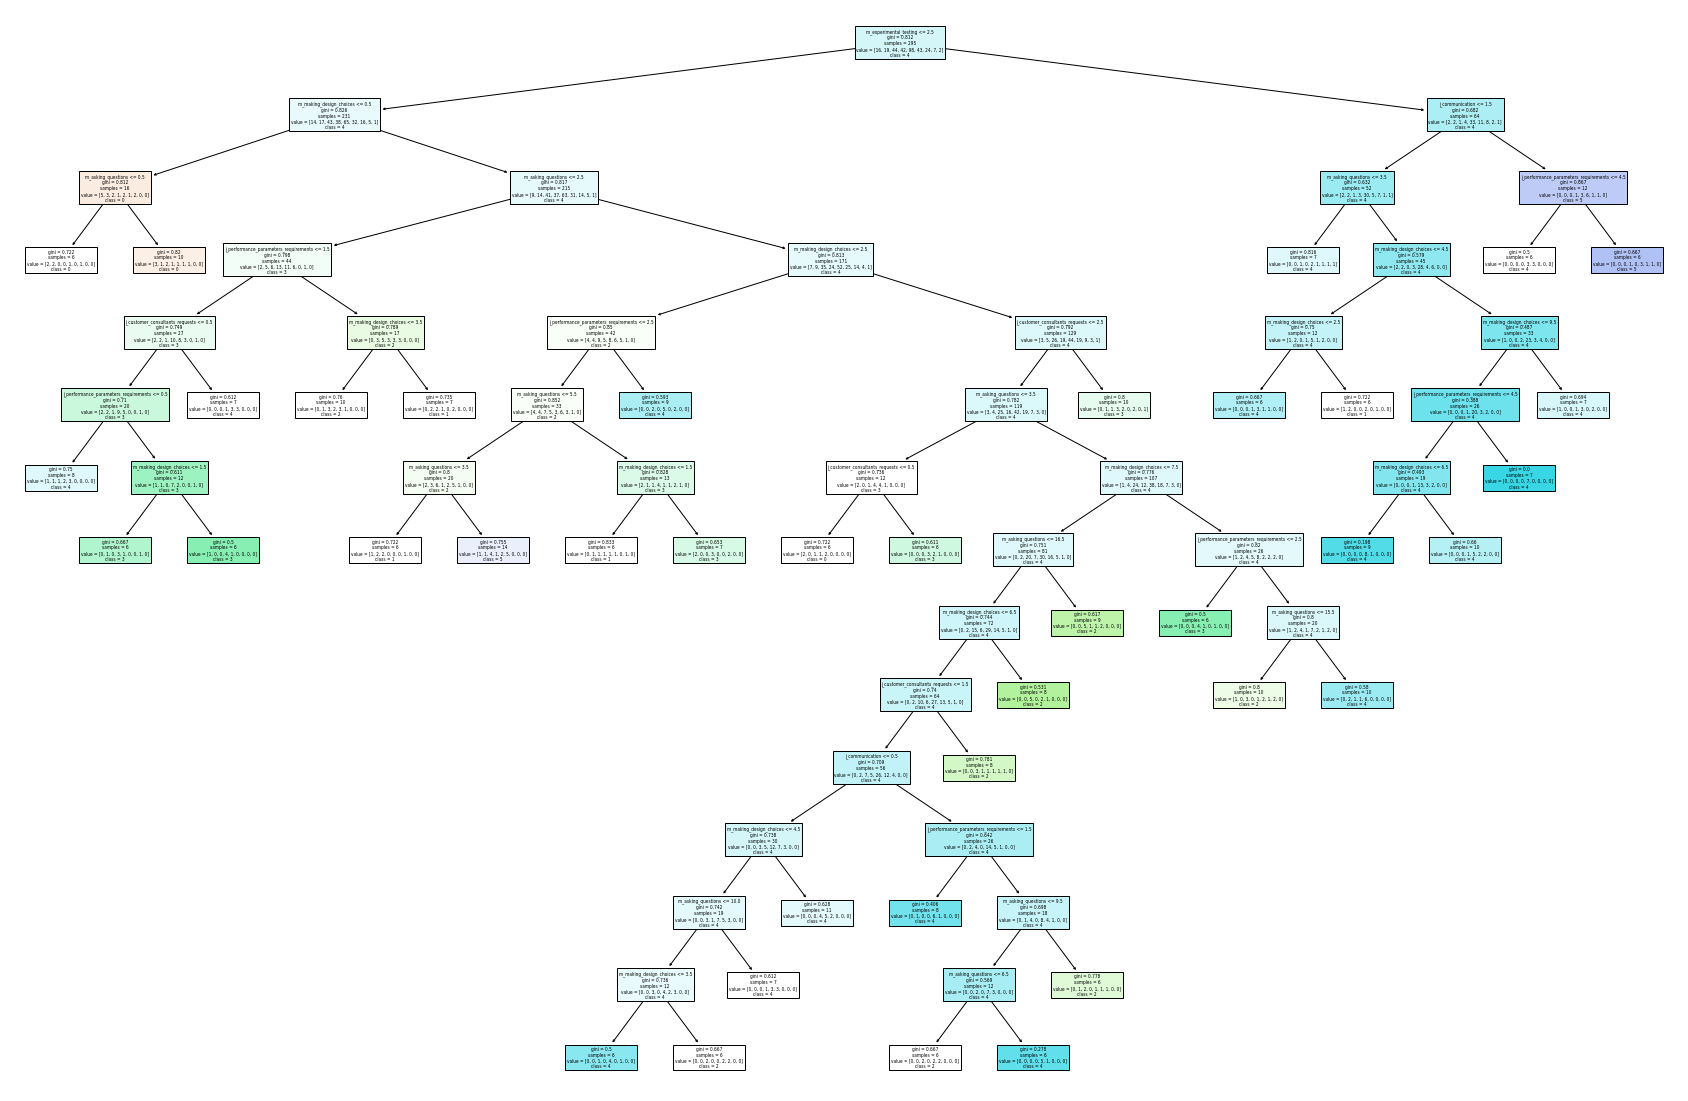

In [24]:
leaf=6

dtc=DecisionTreeClassifier(min_samples_leaf=leaf,random_state=RS)
dtc.fit(X_train,y_train)
Y_pred = dtc.predict(X_test)
fig, ax = plt.subplots(figsize=(30,20)) 
plot_tree(dtc, 
 filled = True, 
 rounded = False, 
 class_names = classes, 
 feature_names = X.columns 
 );
plt.show()

In [25]:
features_list=list(X.columns)
feature_importances=dtc.feature_importances_
for importance,feat in zip(feature_importances,features_list):
    print(f"{feat} feature importance: {importance}")

m_experimental_testing feature importance: 0.09753695798284226
m_making_design_choices feature importance: 0.2879207120821278
m_asking_questions feature importance: 0.26459964454972795
j_customer_consultants_requests feature importance: 0.09900328721606022
j_performance_parameters_requirements feature importance: 0.18199960201347118
j_communication feature importance: 0.06893979615577062


The gini scores are still extremely high in the decision tree plot, indicating strong signs of misclassification. To affirm that this is the case, a decision boundary plot with the accuracy shown can be generated. Additionally, there is no clear factor that explains the variance in outcome score, citing an inappropriate result for determining the most prominent variables influencing the target variable.

No handles with labels found to put in legend.


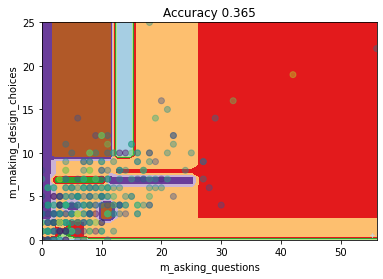

In [26]:
feature1='m_asking_questions'
feature2='m_making_design_choices'
X = X[[feature1,feature2]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 ,random_state=RS)
dtc=DecisionTreeClassifier(min_samples_leaf=leaf,criterion='gini',random_state=RS)
dtc.fit(X_train,y_train)
Y_pred=dtc.predict(X_test)
plt.title('Accuracy {0}'.format(np.round(accuracy_score(y_test, Y_pred),3)))
plt.xlabel(feature1)
plt.ylabel(feature2);
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
xx, yy = np.meshgrid(np.linspace(X.m_asking_questions.min(),X.m_asking_questions.max()), 
                     np.linspace(X.m_making_design_choices.min(),X.m_making_design_choices.max()))
plt_decision_boundaries(dtc,xx,yy)
plt.scatter(X[feature1], X[feature2], c=y, alpha=0.4);
#plot legend here
plt.show()

As observed in the decision boundary,there is significant evidence of overfitting. However, there are multiple regions classifying outcome scores to students, which is somewhat promising. A method to combat the effect of overfitting, a random forest can be used and optimised over a similar scope of parameters.

### Random Forests

To combat the issue of having high variance, previously posed by decision trees, the next model used will be random forest classifiers which will lower the variance as much as possible. The random forest classifier algorithm operates analogously to a series of repeated decision tree classifiers under different randomised conditions and retains the aggregate result of the repeated operations as the output. This combats the issue of bias because of the repeating mechanism running the decision tree classifier on a greater area of the data set. GridSearchCV will be the optimisation mechanism used.

In [27]:
X=teams.drop(['OutcomeScore'],axis=1)
y=teams['OutcomeScore']
X_train, X_test, y_train, y_test =train_test_split(X,y,train_size=0.8,random_state=RS)
grid_space={'n_estimators':[10,100,200],
            'min_samples_leaf':range(1,10)
           }#cross validation process
rf=RandomForestClassifier(random_state=RS)
grid = GridSearchCV(estimator=rf,param_grid=grid_space,cv=3,scoring='accuracy')
model_grid = grid.fit(X_train,y_train)
print('Best hyperparameters are: '+str(model_grid.best_params_))


Best hyperparameters are: {'min_samples_leaf': 8, 'n_estimators': 100}


In [28]:
samples_leaf=8
estimators=100


df_dtc = RandomForestClassifier(n_estimators=estimators,
                                min_samples_leaf=samples_leaf,
                                random_state=RS) 
df_dtc = df_dtc.fit(X_train, y_train) 
Y_pred = df_dtc.predict(X_test) 
for name, score in zip(X.columns, df_dtc.feature_importances_):
    print(name,np.round(score,3))

m_experimental_testing 0.195
m_making_design_choices 0.239
m_asking_questions 0.218
j_customer_consultants_requests 0.1
j_performance_parameters_requirements 0.185
j_communication 0.063


None of the factors are significant in determining outcome score which may be an issue when producing results since random forests utilise a series of decision trees to reduce bias and have more definitively asserted that no factors affect outcome score.

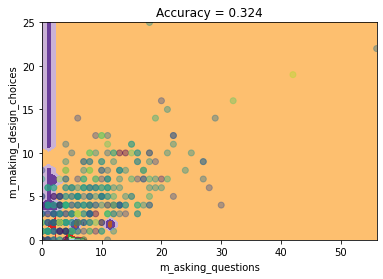

In [29]:
X=teams.drop(['OutcomeScore'],axis=1)
y=teams['OutcomeScore']
X_train, X_test, y_train, y_test =train_test_split(X,y,test_size=0.2,random_state=RS)
feature1='m_asking_questions'
feature2='m_making_design_choices'
X = X[[feature1,feature2]]
y=np.array(y).flatten()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RS,test_size=0.2)

xx, yy = np.meshgrid(np.linspace(X.m_asking_questions.min(),X.m_asking_questions.max()), 
                     np.linspace(X.m_making_design_choices.min(),X.m_making_design_choices.max()))
df_dtc = RandomForestClassifier(n_estimators=estimators,
                                min_samples_leaf=samples_leaf,
                                random_state=RS)   
df_dtc = df_dtc.fit(X_train, y_train) 
Y_pred = df_dtc.predict(X_test)
plt_decision_boundaries(df_dtc,xx,yy)

plt.scatter(X.iloc[:,0],X.iloc[:,1],c=y, alpha=0.4);
plt.title('Accuracy = {0}'.format(np.round(accuracy_score(y_test, Y_pred),3)))
plt.xlabel(feature1)
plt.ylabel(feature2)
#plot legend here
plt.show()

As shown in the decision boundary, it is indeed evident that the random forests classifier significantly reduced overfitting. However, this was at the cost of reducing the accuracy of classification. This may be because the random forests algorithm was unable to sufficiently tackle the issue with high bias in the data set. A concrete example of this bias was that an overwhelming majority of interns achieved a single outcome score over the rest.

### SVM classifier

One of the models used in the project was Support vector machines (SVMs) which are a type of supervised learning algorithm that can be used for classification and regression tasks. They work by finding a hyperplane that separates different classes of data, and they use kernel functions to transform the data into a higher-dimensional space where it can be more easily separated. This model was used due to its effectiveness in dealing with multidimensional data sets and its ability to work with non-linearly separable data. 


In [30]:
X=teams.drop(['OutcomeScore'],axis=1)
y=teams['OutcomeScore']
X_train, X_test, y_train, y_test =train_test_split(X,y,test_size=0.2, random_state=RS)
grid_space={'kernel':['rbf','sigmoid','linear'],
            'C':[0.1,1,10,100],
            'gamma': [0.01,0.1,1]
           }#cross validation process
svc=SVC(random_state=RS)
grid = GridSearchCV(estimator=svc,param_grid=grid_space,cv=3,scoring='accuracy')
model_grid = grid.fit(X_train,y_train)
print('Best hyperparameters are: '+str(model_grid.best_params_))


Best hyperparameters are: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}


In [60]:
C=10
gamma=1
svc = SVC(kernel='rbf',C=C,gamma=1)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

In [50]:
print(f"Accuracy:",np.round(accuracy_score(y_test, y_pred),3))

Accuracy: 0.297


Text(0.5, 1.0, 'Importance of categorical variables on outcome score')

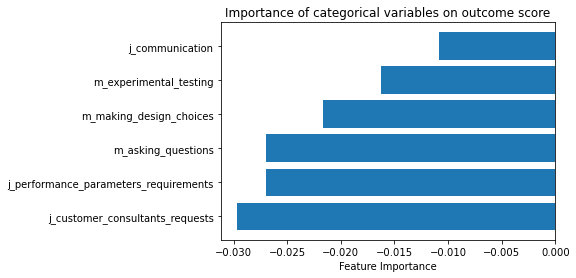

In [33]:
from sklearn.inspection import permutation_importance
%matplotlib inline
perm_importance = permutation_importance(svc, X_test, y_test,random_state=RS)

feature_names = list(X.columns)
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Importance of categorical variables on outcome score")

In [45]:
def plt_decision_boundaries(skm,X):
    """
    Takes a sklearn model (skm) with two features specified by the (N,2) array X and plots the decision boundaries.
    """
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1 # find the minimum and maximum of the first feature
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1 # find the minimum and maximum of the second feature
    # create a rectangular grid which goes from the minimum to maximum values in step-size of h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h)) 
    # ravel is a numpy method which converts a two-dimensional array of size (n,m) to a vector of length nm
    # column_stack is a numpy function which takes two column arrays of length N 
    # and creates a two-dimensional array of size (N,2)
    # now pass the (N,2) array to the model and predict values based on these features, zz will have size (N,1)
    zz = skm.predict(np.column_stack([xx.ravel(), yy.ravel()]))  
    zz = zz.reshape(xx.shape) # reshape zz so it has the size of the original array xx, i.e., (n,m)
    plt.contourf(xx, yy, zz, cmap=plt.cm.Paired) # plot the decision boundaries as filled contours

In [54]:
teams.iloc[:,0:7]

,,,m_experimental_testing,m_making_design_choices,m_asking_questions,j_customer_consultants_requests,j_performance_parameters_requirements,j_communication,OutcomeScore
userIDs,implementation,group_id,,,,,,,
2,a,2,2,4,17,0,4,0,4
3,a,2,1,4,3,0,1,0,4
4,a,2,2,2,3,1,5,0,4
5,a,2,0,0,6,0,2,0,2
6,a,2,0,2,7,1,3,0,2
...,...,...,...,...,...,...,...,...,...
389,o,6,2,8,4,1,7,0,7
390,o,6,0,5,6,1,2,0,4
391,o,6,2,3,11,1,4,0,5


In [111]:
# teams.iloc[:,[0,1].values
data=teams.iloc[:,[0,1,6]].values
df = pd.DataFrame(data, columns=['m_experimental_testing','m_making_design_coices','OutcomeScore'])
df

,m_experimental_testing,m_making_design_coices,OutcomeScore
0,2,4,4
1,1,4,4
2,2,2,4
3,0,0,2
4,0,2,2
...,...,...,...
364,2,8,7
365,0,5,4
366,2,3,5
367,2,4,5


In [110]:
data1=teams['OutcomeScore'].values

array([4, 4, 4, 2, 2, 5, 4, 4, 4, 4, 3, 5, 2, 0, 4, 4, 4, 0, 2, 4, 3, 2,
       5, 1, 4, 0, 1, 4, 2, 2, 2, 2, 4, 4, 0, 2, 4, 4, 4, 4, 1, 3, 4, 3,
       4, 4, 3, 4, 3, 4, 4, 4, 5, 5, 3, 2, 2, 4, 5, 4, 4, 2, 5, 1, 4, 1,
       0, 5, 2, 4, 2, 2, 5, 3, 4, 5, 4, 2, 4, 3, 4, 4, 2, 2, 2, 4, 4, 4,
       0, 3, 3, 2, 6, 4, 1, 4, 1, 1, 2, 5, 5, 5, 4, 6, 4, 1, 4, 3, 4, 6,
       7, 2, 0, 2, 4, 4, 4, 4, 4, 4, 2, 5, 6, 3, 5, 4, 4, 4, 5, 1, 3, 1,
       5, 5, 4, 2, 6, 4, 3, 5, 6, 4, 5, 2, 2, 3, 3, 6, 4, 1, 7, 4, 4, 0,
       4, 5, 4, 5, 3, 4, 4, 3, 4, 4, 4, 0, 0, 5, 5, 3, 3, 4, 2, 2, 6, 4,
       1, 4, 5, 5, 6, 7, 1, 3, 3, 3, 3, 4, 5, 5, 5, 7, 5, 1, 4, 4, 1, 5,
       5, 3, 5, 5, 2, 4, 5, 6, 4, 2, 6, 4, 3, 2, 6, 6, 6, 7, 4, 3, 5, 0,
       2, 3, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 3, 2, 1, 4, 3, 5, 5, 4, 3, 3,
       2, 6, 4, 2, 3, 5, 5, 6, 5, 5, 6, 2, 1, 2, 3, 2, 4, 5, 3, 3, 2, 4,
       4, 2, 1, 6, 4, 6, 5, 6, 0, 2, 3, 4, 4, 5, 3, 4, 6, 4, 0, 3, 0, 3,
       2, 1, 5, 4, 3, 4, 6, 3, 2, 4, 2, 4, 4, 0, 1,

In [125]:
X1=teams.iloc[:,[0,1]].values
y1=teams.iloc[:,6].values
X1_train, X1_test, y1_train, y1_test =train_test_split(X1,y1,test_size=0.2, random_state=RS)

In [121]:
grid_space={'kernel':['rbf','sigmoid','linear'],
            'C':[0.1,1,10,100],
            'gamma': [0.01,0.1,1]
           }#cross validation process
svc=SVC(random_state=RS)
grid = GridSearchCV(estimator=svc,param_grid=grid_space,cv=3,scoring='accuracy')
model_grid = grid.fit(X1_train,y1_train)
print('Best hyperparameters are: '+str(model_grid.best_params_))

Best hyperparameters are: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}


In [126]:
X1

array([[ 2,  4],
       [ 1,  4],
       [ 2,  2],
       [ 0,  0],
       [ 0,  2],
       [ 2,  4],
       [ 3,  5],
       [ 5,  9],
       [ 0,  3],
       [ 0,  0],
       [ 1,  1],
       [ 0,  1],
       [ 0,  2],
       [ 3,  3],
       [ 7,  3],
       [ 1,  1],
       [ 4,  5],
       [ 2, 10],
       [ 1,  1],
       [ 7,  2],
       [ 1,  5],
       [ 0,  9],
       [ 0,  1],
       [ 0,  5],
       [ 1,  7],
       [ 0,  5],
       [ 1,  1],
       [ 0,  5],
       [ 0,  7],
       [ 0,  1],
       [ 1, 16],
       [ 0,  4],
       [ 0,  1],
       [ 0,  8],
       [ 0,  2],
       [ 2, 14],
       [ 0,  4],
       [ 0,  5],
       [ 0,  3],
       [ 0,  5],
       [ 0,  0],
       [ 0,  1],
       [15,  2],
       [ 3,  0],
       [ 0,  1],
       [ 1,  1],
       [ 4,  3],
       [ 2,  2],
       [ 0,  4],
       [ 0,  4],
       [ 3,  9],
       [ 0,  0],
       [ 3,  2],
       [ 1,  1],
       [ 0,  3],
       [ 0,  2],
       [ 0,  4],
       [ 1,  2],
       [ 2,  8

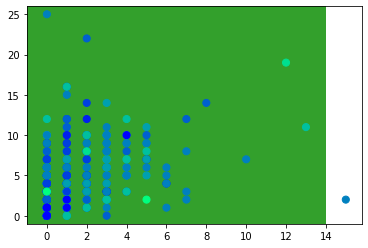

In [128]:
C=0.1
gamma=0.01
svc = SVC(kernel='rbf',C=C,gamma=0.01)
svc.fit(X1_train, y1_train)
y1_pred = svc.predict(X1_test)
plt_decision_boundaries(svc, X1_train) # plot the decision boundaries
plt.scatter(X1[:,0], X1[:,1], c=y, s=50, cmap='winter'); # scatter plot of X labelled by y

In [98]:
y1_pred

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4])

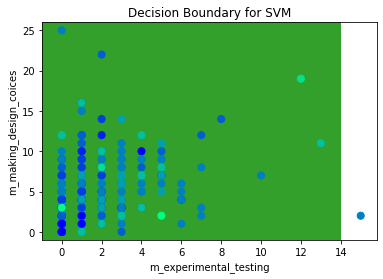

In [133]:
C=0.1
gamma=0.01
svc = SVC(kernel='rbf',C=C,gamma=0.01,degree=3)
svc.fit(X1_train, y1_train)
y1_pred = svc.predict(X1_test)
plt_decision_boundaries(svc, X1_train) # plot the decision boundaries
plt.scatter(X1[:,0], X1[:,1], c=y, s=50, cmap='winter'); # scatter plot of X labelled by y
plt.xlabel('m_experimental_testing')
plt.ylabel('m_making_design_coices')
plt.title('Decision Boundary for SVM')
plt.show()